In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

In [2]:
def iou_list(GT_labels, pred_labels):
    gt_label_list = np.unique(GT_labels)
    
    pred_label_list = np.unique(pred_labels)
    current_accum = []

    for label_i in pred_label_list:
        pred_mask = pred_labels == label_i


        values, counts = np.unique(GT_labels[pred_mask>0], return_counts=True)

        ind = np.argmax(counts)
        gt_label = values[0]        

        true_mask = GT_labels == gt_label


        current_jacc = (np.sum(np.logical_and(true_mask, pred_mask)) /
            np.sum(np.logical_or(true_mask, pred_mask)))

        current_accum.append(current_jacc)

    return current_accum

In [3]:
import tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm

In [4]:
# build the colormap with iterative tab10
tab20 = cm.get_cmap('tab20', 10)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)

newmap = cm.get_cmap('tab20', 4000+1)
newmap.colors = tab20.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

In [5]:
newmap.colors[:20,:]

array([[0.        , 0.        , 0.        , 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.96862745, 0.71372549, 0.82352941, 1.        ],
       [0.78039216, 0.78039216, 0.78039216, 1.        ],
       [0.85882353, 0.85882353, 0.55294118, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.96862745, 0.71372549,

In [6]:


GT_labels = tifffile.imread('D:/Ding/UChicago/cellsegmentation/data/stardist3Ddata/label_8_GT.tif')
pred_labels = tifffile.imread('D:/Ding/UChicago/cellsegmentation/data/stardist3Ddata/pred_label_z8_t133.tiff')

pred_labels = (pred_labels+2)*(pred_labels>0)
GT_labels = (GT_labels+2)*(GT_labels>0)


gt_label_list = np.unique(GT_labels)   
pred_label_list = np.unique(pred_labels)
current_accum = []

iou_table = pd.DataFrame(columns={'seg_label','GT_lable','iou'})

for label_i in pred_label_list:
    if(label_i==0 or label_i >100000000000):
        continue

    pred_mask = pred_labels == label_i

    map_list = GT_labels[pred_mask>0]
    map_list = map_list[map_list>0]

    if(map_list.shape[0]==0):
        current_accum.append(0)
        current_jacc = 0
        current_accum.append(current_jacc)
        s = pd.Series([label_i, 0,current_jacc], index=['seg_label','GT_lable','iou'])
        iou_table = iou_table.append(s,ignore_index=True)
        continue

    values, counts = np.unique(map_list, return_counts=True)

    ind = np.argmax(counts)
    gt_label = values[ind]     

    true_mask = GT_labels == gt_label

    union = pred_mask.astype(int) + 2 * true_mask.astype(int)

    [ind_x, ind_y] = np.where(union>0)

    min_x = min(ind_x)-2
    max_x = max(ind_x)+2
    min_y = min(ind_y)-2
    max_y = max(ind_y)+2
    

    

    current_jacc = (np.sum(np.logical_and(true_mask[min_x:max_x, min_y:max_y], pred_mask[min_x:max_x, min_y:max_y])) /
        np.sum(np.logical_or(true_mask[min_x:max_x, min_y:max_y], pred_mask[min_x:max_x, min_y:max_y])))


    current_accum.append(current_jacc)
    cropX, cropY = np.meshgrid(np.arange(0,pred_mask[min_x:max_x, min_y:max_y].shape[1]), np.arange(0,pred_mask[min_x:max_x, min_y:max_y].shape[0]))
    

    fig, ax = plt.subplots(2,3, figsize=(12,6), dpi=256, facecolor='w', edgecolor='k')
    ax[0,0].imshow(pred_mask[min_x:max_x, min_y:max_y].astype(int)*1, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
    ax[0,0].axis('off')
    ax[0,0].title.set_text('seg_label='+"%d" % label_i)

    ax[0,1].imshow(true_mask[min_x:max_x, min_y:max_y].astype(int)*2, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
    ax[0,1].axis('off')
    ax[0,1].title.set_text('GT_label='+"%d" % gt_label)
    
    ax[0,2].imshow( pred_mask[min_x:max_x, min_y:max_y].astype(int)*1 + 2 * true_mask[min_x:max_x, min_y:max_y].astype(int), cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
    ax[0,2].axis('off')
    # ax[0,2].contour(cropX, cropY, pred_mask[min_x:max_x, min_y:max_y].astype(int)* true_mask[min_x:max_x, min_y:max_y].astype(int),1,colors=('yellow'),linewidths=0.5)
    ax[0,2].title.set_text('iou='+"%.2f" % current_jacc)


    X, Y = np.meshgrid(np.arange(0,pred_labels.shape[1]), np.arange(0,pred_labels.shape[0]))
    
    ax[1,0].imshow(pred_labels, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
    ax[1,0].axis('off')
    ax[1,0].plot( [min_y,max_y,max_y,min_y,min_y],[min_x,min_x,max_x,max_x,min_x])
    ax[1,0].contour(X, Y, pred_mask,1,colors=('yellow'),linewidths=0.7)
                
    
    ax[1,1].imshow(GT_labels, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
    ax[1,1].axis('off')
    ax[1,1].contour(X, Y, true_mask,1,colors=('yellow'),linewidths=0.7)
    ax[1,1].plot( [min_y,max_y,max_y,min_y,min_y],[min_x,min_x,max_x,max_x,min_x])
    ax[1,2].axis('off')
    fig.savefig(os.path.join('D:/Ding/UChicago/cellsegmentation/data/stardist3Ddata/iou/','seg'+str(label_i) + '_GT'+str(gt_label)+'.png'))

    plt.close(fig)      

    s = pd.Series([label_i, gt_label,current_jacc], index=['seg_label','GT_lable','iou'])
    iou_table = iou_table.append(s,ignore_index=True)
    



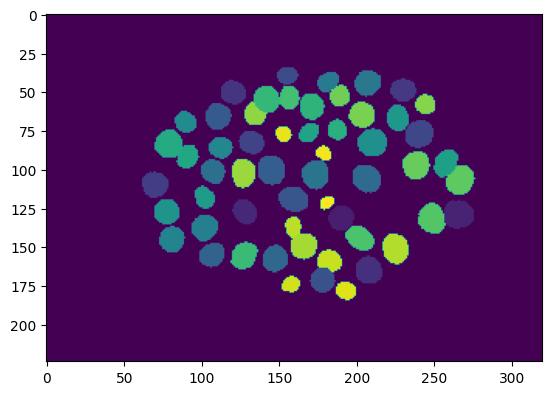

In [7]:
plt.imshow((pred_labels+2)*(pred_labels>0))

In [8]:
pred_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
label_i

58

In [10]:
true_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
'iou='+str(current_jacc)

'iou=0'

In [12]:
iou_table

,seg_label,GT_lable,iou
0,3.0,135.0,0.897196
1,4.0,42.0,0.747405
2,5.0,101.0,0.608247
3,6.0,44.0,0.800813
4,7.0,113.0,0.881057
5,8.0,22.0,0.867347
6,9.0,26.0,0.827586
7,10.0,111.0,0.868687
8,11.0,43.0,0.716475
9,12.0,81.0,0.793388


In [13]:
union = pred_mask.astype(float) + 2 * true_mask.astype(float)

[a,b] = np.where(union>0)

In [14]:
b

array([149, 150, 151, 152, 153, 154, 155, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 148, 149, 150, 151, 152, 153, 154, 155, 156, 149,
       150, 151, 152, 153, 154, 155, 150, 151, 152, 153, 154, 151, 152,
       153, 180, 181, 182, 183, 184, 178, 179, 180, 181, 182, 183, 184,
       185, 177, 178, 179, 180, 181, 182, 183, 184, 185, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 177, 178, 179, 180, 181, 182, 183, 184, 177, 178, 179,
       180, 181, 182, 183, 177, 178, 179, 180, 181, 182, 179], dtype=int64)

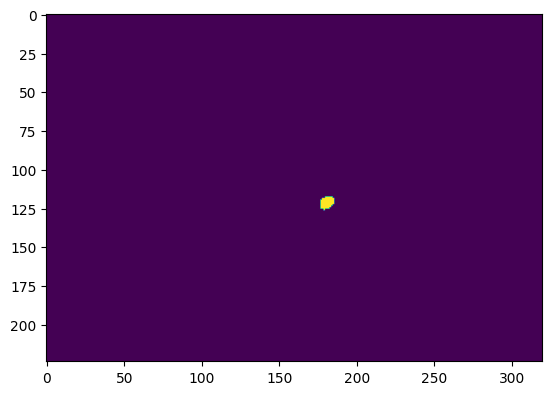

In [15]:
plt.imshow(pred_mask)

In [16]:
pred_mask.astype(np.float)

c:\Users\dingl\anaconda3\envs\segmentation\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
pred_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
pred_label_list

array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58], dtype=uint16)

In [19]:
gt_label_list

array([  0.,   5.,   8.,  13.,  16.,  18.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  29.,  30.,  31.,  34.,  35.,  37.,  42.,  43.,  44.,
        49.,  57.,  60.,  68.,  69.,  70.,  73.,  79.,  81.,  82.,  83.,
        84.,  86.,  88.,  90.,  93.,  96.,  98.,  99., 101., 103., 106.,
       110., 111., 113., 127., 130., 135., 136., 138., 142., 144., 159.,
       166., 175., 183., 184., 187.], dtype=float32)

Text(0, 10, 'Precision=0.72')

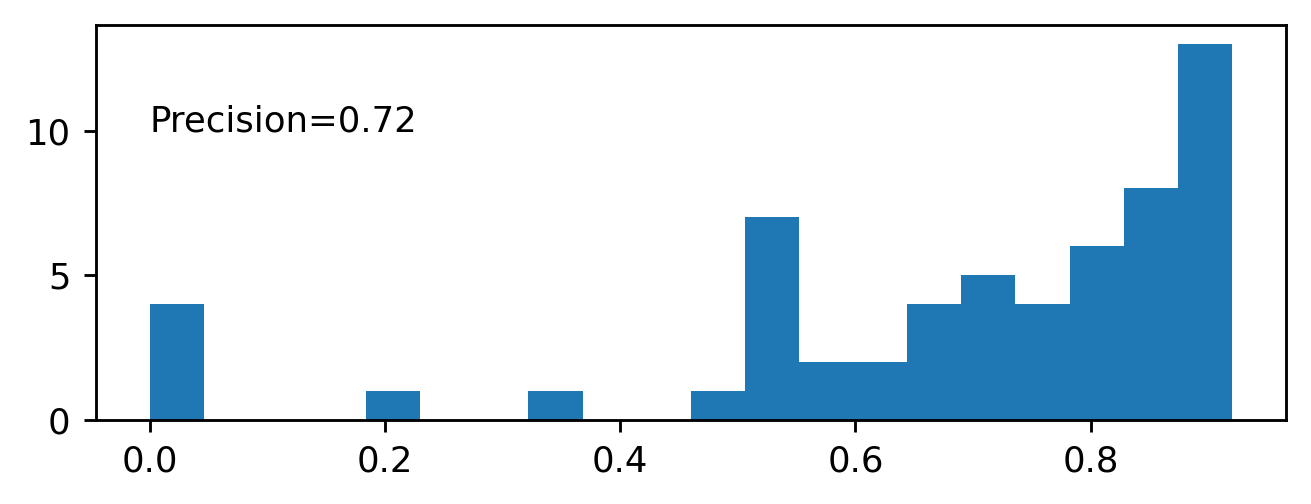

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6,2), dpi=256, facecolor='w', edgecolor='k')
plt.hist(current_accum,20)
res = np.array(current_accum)
plt.text(0,10,'Precision='+ "%.2f" % (res[res>0.6].shape[0]/res.shape[0]))

In [33]:

res = np.array(current_accum)

In [48]:
res[res>0.6].shape[0]/res.shape[0]



0.7241379310344828

NameError: name 'length' is not defined